In [14]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [15]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20211107"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [16]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str30,str11,object,float64,int64,int64
Ast1-001R.fit,Light Frame,Bessel R,60.0,1024,1024
Ast1-002R.fit,Light Frame,Bessel R,60.0,1024,1024
Ast2-001R.fit,Light Frame,Bessel R,60.0,1024,1024
Ast2-001V.fit,Light Frame,Bessel V,60.0,1024,1024
Asteroid 3-001V.fit,Light Frame,Bessel V,60.0,1024,1024
Asteroid3-001V.fit,Light Frame,Bessel V,60.0,1024,1024
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024


In [17]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [18]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [19]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [20]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

777.5722813606262 1.4826
773.0 785.7483880782432


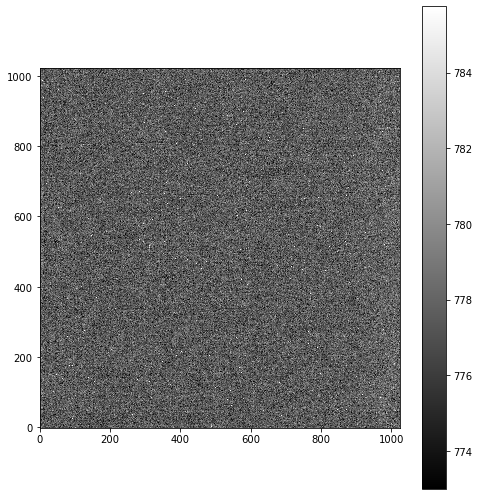

In [21]:
show_image(combined_bias)

0.19259336789449066 0.07412999999999997
-0.06666666666666667 0.5690400824705956


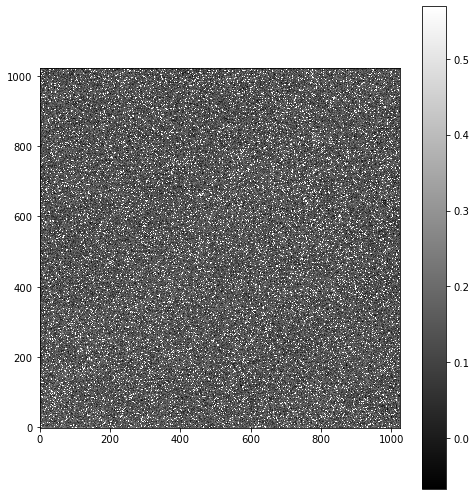

In [22]:
show_image(combined_darks)

1.0000217873074546 0.005912666303594838
0.9685906618114586 1.0198191467762046


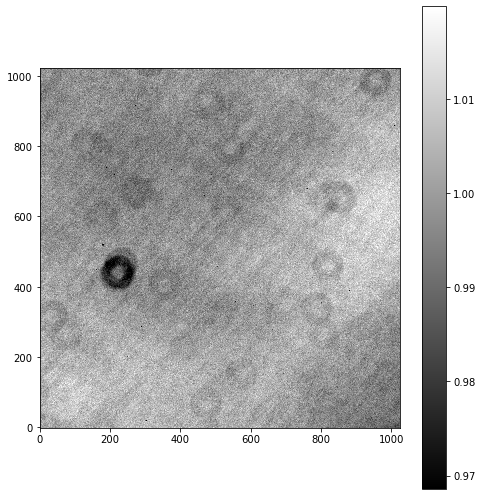

0.9998023718084218 0.006212409273850495
0.9691827031737754 1.0179252459686032


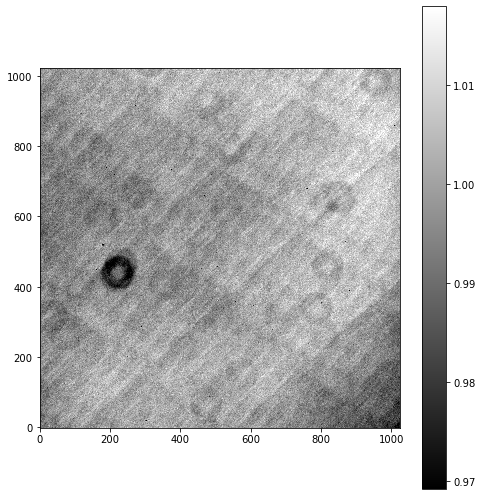

1.0015412989441366 0.006899928726693106
0.9671734330801309 1.0417620573282118


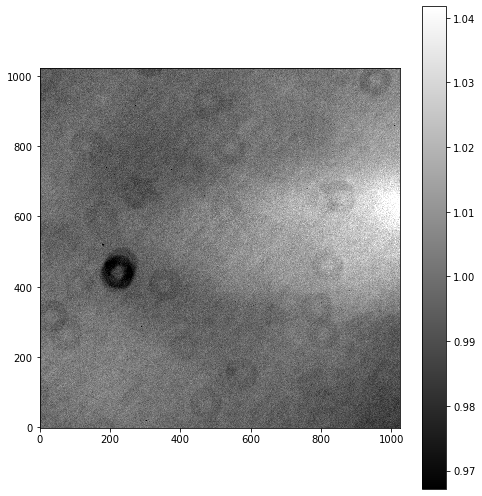

In [23]:
for filt,image in master_flats.items():
    show_image(image)

In [24]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
117.5166603586851 9.647673848884697
87.71095974219352 174.69584913797368


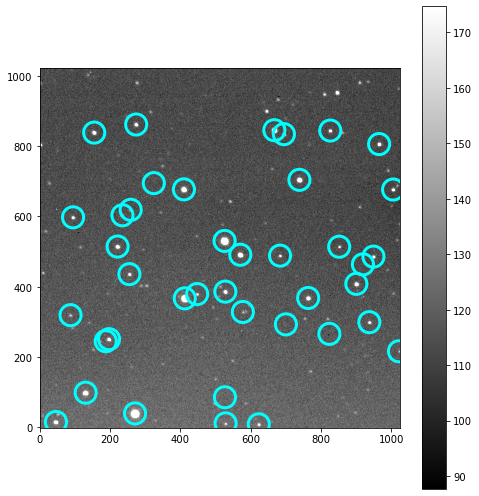

      xcentroid   ycentroid       mag
3    270.773206   39.756781 -4.931004
26   525.515631  530.521354 -4.593347
14   412.229373  367.105695 -4.258222
31   409.813881  677.189481 -2.669598
38   667.052314  845.495468 -2.507145
23   570.183029  491.189542 -2.504504
33   738.384548  704.305110 -2.478054
15   763.322012  368.190686 -2.122922
5    130.346092   98.705825 -2.119843
18   900.431384  408.329548 -1.832274
17   527.655571  386.207407 -1.435066
34   965.163976  806.082724 -1.321805
2     45.720491   15.404961 -1.242069
24   221.222044  514.476385 -1.052902
30  1004.948359  676.648107 -1.018295
8    196.730111  250.967061 -0.982985
37   826.165179  844.485988 -0.934472
21   949.060910  485.815206 -0.909131
36   154.588724  838.662440 -0.890717
11   937.295258  299.324771 -0.801654
39   273.971974  861.733347 -0.712079
0    622.911414    8.668503 -0.693023
35   694.377871  834.279241 -0.671022
9    823.675090  266.004793 -0.392991
22   683.318824  488.667518 -0.347526
28   234.885

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)


In [31]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH-And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
118.75330476095316 9.686730354786619
80.91251394876814 175.0606273430426


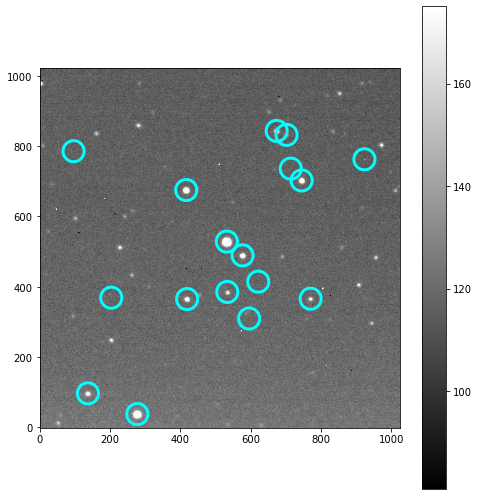

     xcentroid   ycentroid       mag
9   532.019838  528.616203 -3.362502
0   277.311883   37.829155 -2.501546
10  416.409395  675.240184 -1.306940
11  744.855859  702.528693 -1.014026
13  923.341101  762.734257 -1.012093
8   576.711840  489.271672 -0.910428
3   418.862010  365.040437 -0.617746
16  673.634348  843.513015 -0.484727
7   621.391097  414.543596 -0.192732
1   136.822790   96.803776 -0.151285
6   533.245397  385.308338 -0.103540
15  701.939717  832.219906 -0.086204
2   595.363829  309.644469 -0.026824
4   770.290505  366.065814 -0.024827
12  713.857511  736.221836 -0.021477
14   95.888355  785.776034 -0.015635
5   203.126617  368.926360 -0.010267
Point RA 23 41 55
Point Dec +44 10 47
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.47916667, 44.17972222)>
radecstr 355.479 44.1797
Search radius = 0.13106342470013851 deg


/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


        ra                dec         phot_bp_mean_mag
       deg                deg               mag       
------------------ ------------------ ----------------
 355.5019035183828 44.198035374175014        10.688043
355.45682608764184   44.1091497298546        10.973479
355.64099415478967  44.12772121179612        11.496982
 355.3306982581766   44.2359279272418        11.909237
355.50456763922585  44.06754318511075        12.128365
355.47999369869643 44.170596761287726        12.559549
355.47001979053437  44.22036113755551        12.621736
 355.3698096839802  44.17781222041276        12.638292
 355.5469803797695  44.23222573087555        13.010126
 355.5136833365018 44.192329310844094        13.069663
355.52571998929113  44.25459544396694        13.205368
355.34150523232074 44.149817243497516         13.58919
 355.4217894072697  44.11604778557108        13.625631
 355.3624371923208  44.26267631796206        13.718818
355.49205599770977 44.293673702845524        13.933575
355.505646

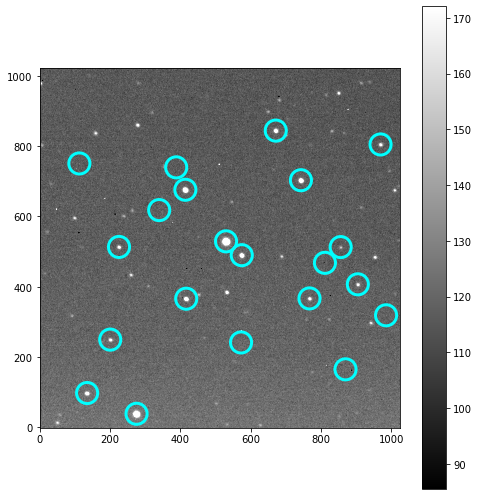

     xcentroid   ycentroid       mag
13  529.704107  529.333732 -4.292115
0   275.050045   38.685301 -3.351848
15  413.954493  676.064804 -2.249571
10  574.353425  489.934828 -1.790157
16  742.713680  703.225681 -1.749059
6   416.364591  366.074619 -1.365419
20  671.142645  844.326431 -1.188176
1   134.441842   97.735681 -0.801763
19  969.234330  804.994207 -0.703547
11  225.163479  513.406817 -0.551618
7   767.093277  366.898230 -0.507303
8   904.614080  407.039859 -0.391482
4   200.163415  249.710888 -0.252020
3   572.341131  241.598985 -0.120244
2   869.633278  165.148358 -0.070598
17  387.887852  739.744779 -0.060263
14  339.442693  618.228665 -0.046016
5   984.994902  318.922389 -0.026839
18  112.339071  750.915887 -0.026816
9   811.070415  468.161093 -0.019094
12  855.809348  512.906238 -0.002134
Point RA 23 41 55
Point Dec +44 10 47
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.47916667, 44.17972222)>
radecstr 355.479 44.1797
Search radius = 0.13106342470013851 deg
      

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)


In [32]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH-And*B.fit')

for path in pathlist:
    #show_image(Rimage)
    Bimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Bimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Bimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
137.34664490245513 9.358120941165003
106.30322315160498 192.27777019520047


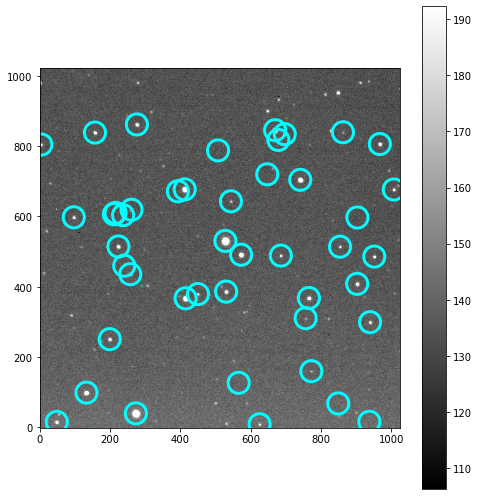

      xcentroid   ycentroid       mag
23   527.777557  530.527657 -5.167326
3    273.199169   39.927874 -5.001993
11   414.635200  367.180655 -3.344372
32   412.065219  677.269761 -3.259179
34   740.768185  704.398401 -2.906974
20   572.484854  491.223459 -2.890469
43   669.301190  845.510211 -2.712376
5    132.581477   98.864465 -2.261537
12   765.439431  368.186477 -1.949019
15   902.731984  408.338954 -1.767893
14   529.899123  386.313990 -1.715473
38   967.180439  806.186443 -1.604822
22   223.477013  514.692456 -1.482774
33  1007.016339  676.825114 -1.315271
44   276.090038  861.803778 -1.314707
8    198.772542  251.038987 -1.263692
41   156.769162  838.842883 -1.224208
1     48.123901   15.578816 -1.218800
18   951.441292  485.977753 -1.207070
40   696.691347  834.256364 -0.997167
9    939.510402  299.350750 -0.936774
16   257.281574  435.900866 -0.842889
24    96.545707  597.765244 -0.790025
21   853.943453  514.068549 -0.702218
13   449.772260  379.281822 -0.612138
19   685.634

In [33]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH-And*V.fit')

for path in pathlist:
    #show_image(Rimage)
    Vimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Vimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Vimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")